# Project: Climate

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

---

### Read data

In [2]:
df=pd.read_csv("climate_data.txt",sep='\s+',skiprows=96)

In [3]:
df.reset_index(level=0, inplace=True)

In [4]:
# Rename columns
df.rename({ 'index':'row_nr',
            '%':'Year', 
           'Year,':'Month',
           'Month,':'Raw_Temp',
           'Temperature,':'Raw_Anomaly',
           'Anomaly,':'QC_Failed',
           'Failed,' : 'Cont_Breaks',
           'Breaks,':'Adj_Temp',
           'Temperature,.1':'Adj_Anomaly',
           'Anomaly,.1':'Reg_Temp', 
           'Temperature,.2':'Exp_Anomaly'}, axis='columns', inplace=True)


In [5]:
del df['Anomaly']

In [6]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'],inplace=True)

In [7]:
df.head()

,row_nr,Year,Month,Raw_Temp,Raw_Anomaly,QC_Failed,Cont_Breaks,Adj_Temp,Adj_Anomaly,Reg_Temp,Exp_Anomaly,Date
Date,,,,,,,,,,,,
1701-01-01,0,1701,1,-4.2,-3.827,0.0,0.0,-4.2,-3.827,NaN,NaN,1701-01-01
1701-02-01,1,1701,2,-1.5,-2.027,0.0,0.0,-1.5,-2.027,NaN,NaN,1701-02-01
1701-03-01,2,1701,3,1.6,-2.470,0.0,0.0,1.6,-2.470,NaN,NaN,1701-03-01
1701-06-01,3,1701,6,15.4,-1.932,0.0,0.0,15.4,-1.932,NaN,NaN,1701-06-01
1701-07-01,4,1701,7,18.9,0.351,0.0,0.0,18.9,0.351,NaN,NaN,1701-07-01


---

### Plot data

In [8]:
import seaborn as sns

In [9]:
#df2=df[df['Year'] >1900]
df2=df[(df['Year'] >1900) & (df['Year'] < 2013)]

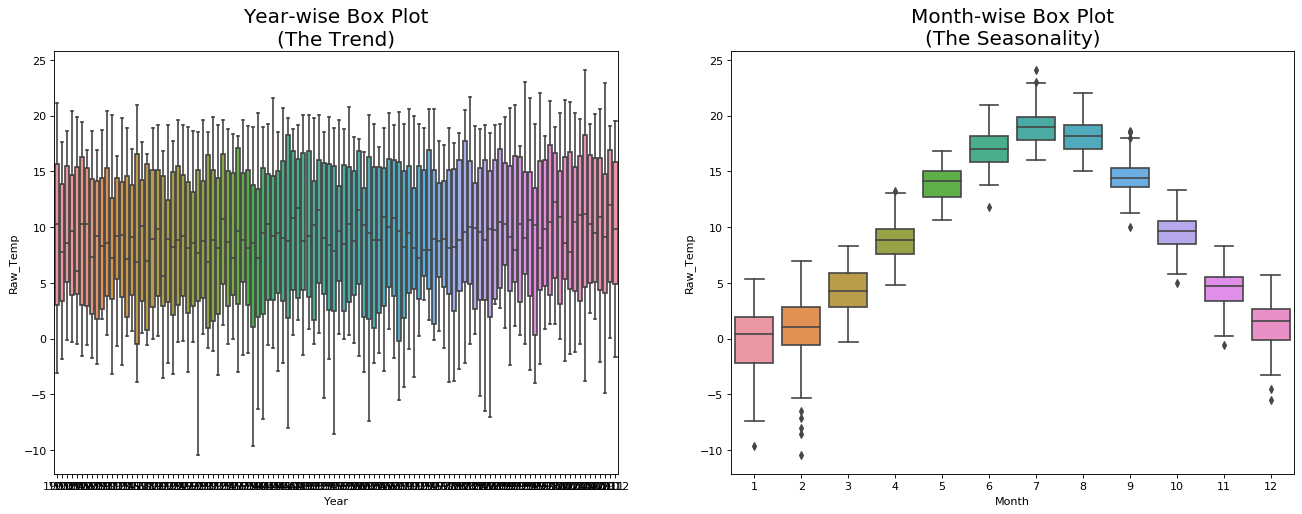

In [10]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Raw_Temp', data=df2, ax=axes[0])
sns.boxplot(x='Month', y='Raw_Temp', data=df2.loc[~df2['Year'].isin([1900, 2013]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

---

### Autocorrelation and Partial Autocorrelation functions

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

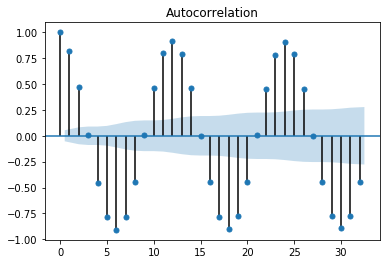

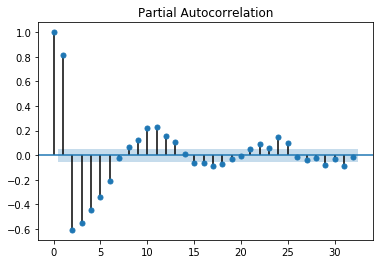

In [12]:
#ACF = Plots lags on the horizontal and the correlations on vertical axis
#add_subplot(211)
plot_acf(df2['Raw_Temp'])

#PACF: The partial autocorrelation at lag k is the correlation that results after removing the 
# effect of any correlations due to the terms at shorter lags.
plot_pacf(df2['Raw_Temp'])
plt.show()


---

### Fill NaNs: no NaNs after 1900

In [ ]:
find_index = df[(df['Year'] >= 1710) & (df['Year'] < 1750)].index
a = df.loc[find_index]['row_nr']
#a
#first_elem = a[0]
#last_elem = a[-1]
#print(first_elem)
#print(last_elem)

In [ ]:
# Check for NaNs
df['Raw_Temp'].isna().sum()

In [ ]:
#nan_index = df[df['Raw_Temp'].isnull()].index
#df.loc[nan_index]

In [ ]:
#Fill NaNs (but takes all years)
#df['Adj_Temp'] = df['Adj_Temp'].fillna(df.groupby('Month')['Adj_Temp'].transform('mean'))

In [ ]:
#Fill NaNs with only data before 1750
def myfillNaN(x):
    m=x.iloc[96:365].mean()
    x.fillna(m,inplace = True)
    return x

In [ ]:
#Apply my function to the df
df['Raw_Temp'] = df['Raw_Temp'].fillna(df.groupby('Month')['Raw_Temp'].transform(myfillNaN))

In [ ]:
#Check if NaNs
df['Raw_Temp'].isna().sum()

---

### Test - Train split

In [13]:
train12, test12 = df2[1:len(df2)-12].copy(), df2[len(df2)-12:].copy()

In [14]:
train60, test60 = df2[1:len(df2)-60].copy(), df2[len(df2)-60:].copy()

### Decompose the time series

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

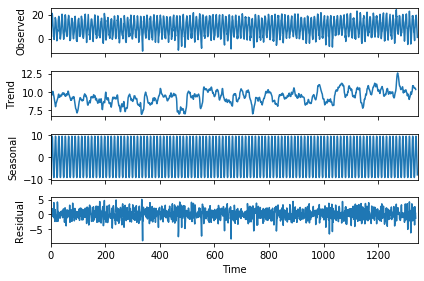

In [16]:
# Additive model: y(t) = Level + Trend + Seasonality + Noise
# uses moving average (for the trend)
sdr = seasonal_decompose(df2['Raw_Temp'].values, freq=12, model='additive')
sdr.plot()
None

In [17]:
df_reconstructed = pd.concat([pd.DataFrame(sdr.seasonal), pd.DataFrame(sdr.trend), pd.DataFrame(sdr.resid),pd.DataFrame(sdr.observed)], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']

In [ ]:
df_reconstructed.head(10)

In [ ]:
df_reconstructed.dropna(inplace=True)

---

In [18]:
# All data
df2['diff'] = df2['Raw_Temp'].diff()

monthmeans = df2.groupby('Month')['diff'].transform('mean')
df2['unseasoned'] = df2['diff']/monthmeans


C:\Users\Nata\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Nata\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
#Remove the trend and seasonality
train12['diff'] = train12['Raw_Temp'].diff()
test12['diff'] = test12['Raw_Temp'].diff()

monthmeans_train_12 = train12.groupby('Month')['diff'].transform('mean')
train12['unseasoned'] = train12['diff']/monthmeans_train_12


In [20]:
#Remove the trend and seasonality
train60['diff'] = train60['Raw_Temp'].diff()
test60['diff'] = test60['Raw_Temp'].diff()

monthmeans_train_60 = train60.groupby('Month')['diff'].transform('mean')
train60['unseasoned'] = train60['diff']/monthmeans_train_60


---

### Table MAE

In [21]:
mae_list = [['1 year',0,0,0],
             ['5 years',0,0,0]]
mae_df = pd.DataFrame(mae_list,columns=['year','BL','AR','ARIMA'])
mae_df.set_index(['year'],inplace=True)

## Baseline model

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [23]:
# create lagged dataset
values = df2['Raw_Temp']
df_bl = pd.concat([values.shift(12), values], axis=1)
df_bl.columns = ['t-12', 't']

In [24]:
# split into train and test sets
X = df_bl.values
train, test = X[1:len(X)-12], X[len(X)-12:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [25]:
# persistence model
def model_persistence(x):
    return x

Test MSE: 3.579
Test MAE: 1.500


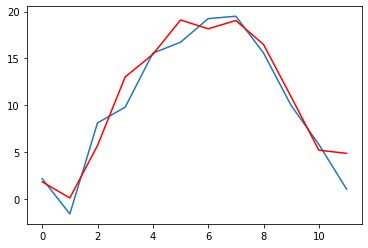

In [26]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

test_score = mean_squared_error(test_y, predictions)
test_score_abs = mean_absolute_error(test_y,predictions)
print('Test MSE: %.3f' % test_score)
print('Test MAE: %.3f' % test_score_abs)

mae_df.iloc[0,0] = test_score_abs
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

In [27]:
#Predict 5 years ahead
# create lagged dataset
values = df2['Raw_Temp']
df_bl2 = pd.concat([values.shift(60), values], axis=1)
df_bl2.columns = ['t-60', 't']

# split into train and test sets
X = df_bl2.values
train, test = X[1:len(X)-60], X[len(X)-60:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


In [28]:
# persistence model
def model_persistence(x):
    return x

Test MSE: 7.412
Test MAE: 2.067


C:\Users\Nata\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


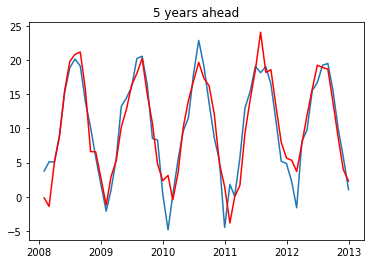

In [29]:
# walk-forward validation
predictions = list()

for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)


test_score = mean_squared_error(test_y,predictions)
test_score_abs = mean_absolute_error(test_y,predictions)
print('Test MSE: %.3f' % test_score)
print('Test MAE: %.3f' % test_score_abs)

mae_df.iloc[1,0] = test_score_abs
# create a random dataframe with datetimeindex
dateRange = pd.date_range(start='1/1/2008', periods=60, freq="M")
randomInts = np.linspace(1, 60, len(dateRange))
df = pd.DataFrame({'RandomValues' : randomInts}, index=dateRange)


        
# plot predictions vs expected
plt.plot(df.index,test_y)
plt.plot(df.index,predictions, color='red')
plt.title("5 years ahead")
plt.show()

### Predict next 10 years

In [30]:
pred_BL_df = df2.iloc[-120:]

In [31]:
pred_BL = pred_BL_df['Raw_Temp']

---

## AR model: 

An autoregression model is a linear regression model that uses lagged variables as input variables

### AR model assumptions:

1- The previous time step(s) is useful in predicting the value at the next time step (dependance between values)

2 - Data is stationary. A time series is stationary if is mean (and/or variance) is constant over time. If the time series  isn’t stationary --> remove trend and seasonality 

In [32]:
from statsmodels.tsa.ar_model import AR
#from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
# Dickey-Fuller test

# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.
#                       It has some time dependent structure.
# Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, 
                       # meaning it is stationary. It does not have time-dependent structure.

# A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), 
# otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [34]:
#Test if stationary
X_train12 = train12['unseasoned']
X_train12.dropna(inplace=True)
X_test12 = test12['Raw_Temp']

X_train60 = train60['unseasoned']
X_train60.dropna(inplace=True)
X_test60 = test60['Raw_Temp']

test_stationarity(X_train12)
#test_stationarity(X_train60)


Results of Dickey-Fuller Test:
Test Statistic                  -34.299790
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1329.000000
Critical Value (1%)              -3.435280
Critical Value (5%)              -2.863717
Critical Value (10%)             -2.567929
dtype: float64


### Predict 1 year

In [35]:
# Test 1 year ahead
#train, test = X[:-12],X[-12:]
m = AR(X_train12)
model_fit = m.fit(maxlag=2)
predictions = model_fit.predict(start=len(X_train12), end=len(X_train12)+len(X_test12)-1, dynamic=True)

C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [36]:
#Predictions --> go back to temp
p=np.array(predictions)
m=np.array(monthmeans_train_12.iloc[11:23])
pred_seas=np.multiply(p,m)
#pred_seas[0]=train12.iloc[-1]['Raw_Temp']
pred_AR_1_yr = pred_seas.cumsum() 

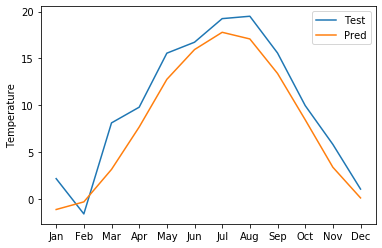

In [37]:
month = np.array(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.plot(month,X_test12,label="Test")
plt.plot(month,pred_AR_1_yr,label="Pred")
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [38]:
error = mean_squared_error(test12['Raw_Temp'], pred_AR_1_yr)
error_abs = mean_absolute_error(test12['Raw_Temp'],pred_AR_1_yr)

mae_df.iloc[0,1] = error_abs

print('Test MSE: %.3f' % error)
print('Test MAE: %.3f' % error_abs)


Test MSE: 6.008
Test MAE: 2.186


---

### Predict 5 years

In [75]:
# Test 1 year ahead
#train, test = X[:-12],X[-12:]
m = AR(X_train60)
model_fit = m.fit(maxlag=4)
predictions = model_fit.predict(start=len(X_train60), end=len(X_train60)+len(X_test60)-1, dynamic=True)

C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [76]:
#Predictions --> go back to temp
p=np.array(predictions)
m=np.array(monthmeans_train_60.iloc[11:71])
pred_seas=np.multiply(p,m)
pred_AR_5_yr = pred_seas.cumsum() 

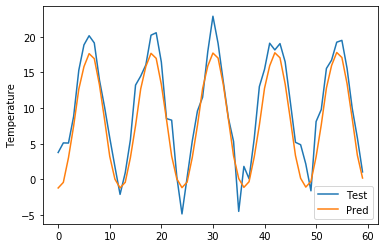

In [41]:
plt.plot(np.array(X_test60),label="Test")
plt.plot(pred_AR_5_yr,label="Pred")
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [42]:
error = mean_squared_error(test60['Raw_Temp'], pred_AR_5_yr)
error_abs = mean_absolute_error(test60['Raw_Temp'],pred_AR_5_yr)
mae_df.iloc[1,1] = error_abs
print('Test MSE: %.3f' % error)
print('Test MAE: %.3f' % error_abs)


Test MSE: 7.749
Test MAE: 2.370


---

### 10 years forecast

In [43]:

X = df2['unseasoned']
X.dropna(inplace=True)

#train, test = X[:-120],X[-120:]
m = AR(X)
model_fit = m.fit(maxlag=4)
predictions_AR = model_fit.predict(start='1/1/2013', end='1/1/2023')
predictions = model_fit.predict(start='1/1/2013', end='1/1/2023')


C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [44]:
#Predictions --> go back to temp
p=np.array(predictions[0:120])
m=np.array(monthmeans[0:120])
pred_seas=np.multiply(p,m)
pred_AR = pred_seas.cumsum() 

In [45]:
df_pred=pd.DataFrame(pred_AR,columns=['pred'])
df_pred['datetime'] = pd.date_range(start='1/1/2013', periods=len(df_pred), freq="M")
df_pred.set_index(df_pred['datetime'],inplace=True)
del df_pred['datetime']

In [46]:
df_past = df2.iloc[-120:]['Raw_Temp'].copy(deep = True)
df_pred = df_pred.copy(deep = True)
df_past.columns = ['past']
df_pred.columns = ['predictions']

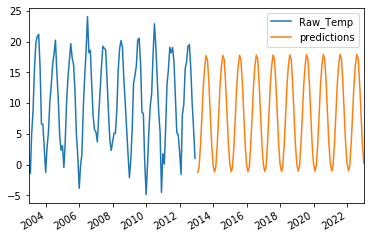

In [47]:
df_all = pd.merge(df_past, df_pred, how = 'outer', left_index=True, right_index=True)
df_all.plot()

---

### ARIMA

In [50]:
from statsmodels.tsa.arima_model import ARIMA

### Predict 1 year

In [51]:
m = ARIMA(X_train12, (2, 0, 2))
m.initialize()
r = m.fit()

C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [52]:
ypred, err, conf = r.forecast(steps=12) 

In [54]:
#Predictions --> go back to temp
p=np.array(ypred)
m=np.array(monthmeans_train_12.iloc[11:23])
pred_seas=np.multiply(p,m)
pred_ARIMA_1_yr = pred_seas.cumsum() 

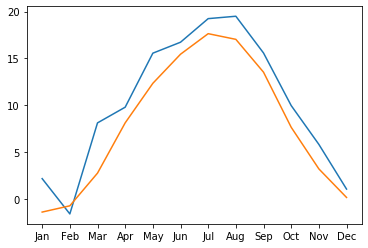

In [55]:
month = np.array(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.plot(month,X_test12,label="Test")
plt.plot(month,pred_ARIMA_1_yr,label="Pred")
#plt.plot(train, color='blue')
#plt.plot(np.array(test_seas_trend), color='black')
#plt.plot(pred_seas_trend, color='red', marker='o')

In [56]:
error = mean_squared_error(X_test12, pred_ARIMA_1_yr)
error_abs = mean_absolute_error(X_test12,pred_ARIMA_1_yr)
mae_df.iloc[0,2] = error_abs
print('Test MSE: %.3f' % error)
print('Test MAE: %.3f' % error_abs)

Test MSE: 6.921
Test MAE: 2.329


---

### Predict 5 year

In [57]:
m = ARIMA(X_train60, (2, 0, 2))
m.initialize()
r = m.fit()

C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


In [58]:
ypred, err, conf = r.forecast(steps=60) 

In [63]:
#Predictions --> go back to temp
p=np.array(ypred)
m=np.array(monthmeans_train_60.iloc[11:71])
pred_seas=np.multiply(p,m)
pred_ARIMA_5_yr = pred_seas.cumsum()

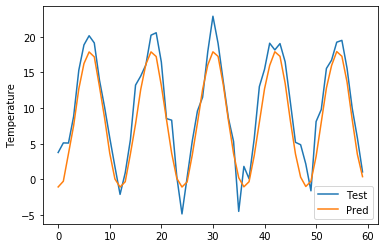

In [64]:
plt.plot(np.array(X_test60),label="Test")
plt.plot(pred_ARIMA_5_yr,label="Pred")
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [65]:
error = mean_squared_error(X_test60, pred_ARIMA_5_yr)
error_abs = mean_absolute_error(X_test60,pred_ARIMA_5_yr)
mae_df.iloc[1,2] = error_abs
print('Test MSE: %.3f' % error)
print('Test MAE: %.3f' % error_abs)

Test MSE: 7.051
Test MAE: 2.242


### Forecast 10 years

In [66]:
X = df2['unseasoned']
X.dropna(inplace=True)

m = ARIMA(X, (2, 0, 2))
m.initialize()
r = m.fit()

ypred, err, conf = r.forecast(steps=120)


C:\Users\Nata\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [67]:
#Predictions --> go back to temp
p=np.array(ypred[0:120])
m=np.array(monthmeans[0:120])
pred_seas=np.multiply(p,m)
pred_ARIMA = pred_seas.cumsum()

In [68]:
df_pred=pd.DataFrame(pred_ARIMA,columns=['pred'])
df_pred['datetime'] = pd.date_range(start='1/1/2013', periods=len(df_pred), freq="M")
df_pred.set_index(df_pred['datetime'],inplace=True)
del df_pred['datetime']

In [69]:
df_past = df2.iloc[-120:]['Raw_Temp'].copy(deep = True)
df_pred = df_pred.copy(deep = True)
df_past.columns = ['past']
df_pred.columns = ['predictions']

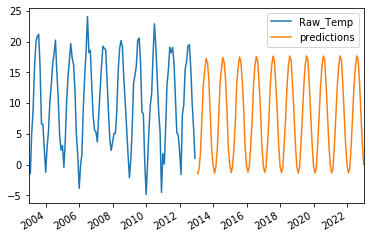

In [70]:
df_all = pd.merge(df_past, df_pred, how = 'outer', left_index=True, right_index=True)
df_all.plot()

---

### Find optimal p,q for ARIMA

In [ ]:
# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set 
# of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other
# models. Thus, AIC provides a means for model selection. 
#Small AIC : good

In [ ]:
from statsmodels.tsa.arima_model import ARMAResults 

In [ ]:
AIC_list = []

for i in range(2,5):
    for j in range(1,3):
        m = ARIMA(X_train60, (i, 0, j))
        m.initialize()
        r = m.fit()
        AIC_list.append(r.aic)
        

In [ ]:
AIC_list

### Predictions all models

In [ ]:
# Baseline model pred_BL
# AR pred_AR
# ARIMA pred_ARIMA

In [71]:
df_pred=pd.DataFrame(pd.Series(pred_BL.values),columns=['pred_BL'])
df_pred['datetime'] = pd.date_range(start='1/1/2013', periods=len(df_pred), freq="M")
df_pred.set_index(df_pred['datetime'],inplace=True)
del df_pred['datetime']

In [72]:
df_pred['AR'] = pred_AR
df_pred['ARIMA'] = pred_ARIMA

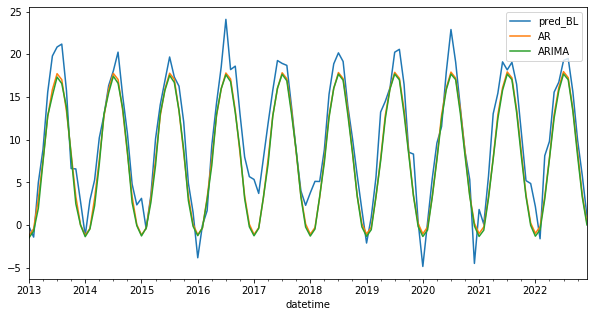

In [73]:
df_pred.plot(figsize=(10, 5))

In [74]:
mae_df

,BL,AR,ARIMA
year,,,
1 year,1.499750,2.185641,2.328514
5 years,2.066533,2.369596,2.242008
